In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [95]:
# Load the data from the CSV file

output_directory = './img/'
df = pd.read_csv('output.csv')
df['Iteration'] = df['InputFileName'].str.extract(r'(\d+)-')

# Monolithic vs Microservices Experiment

Calculating joules

$E=P.\Delta t$

`Joules = Watts * Time in Seconds`

# Todo
- Analyse Average Watts per iteration ✅
- Calculate Joules per iteration ✅
- Analyse Energy Consumption in Joules per Iteration ✅
- Break down Energy Consumption by Frontend and Backend
- Analyse Temperature per Iteration and compare to Energy Consumption
- Analyse C State per iteration



In [96]:
# Calculate the Joules for each file name
time_column = ''

for file_name in df['InputFileName'].unique():
    subset = df[df['InputFileName'] == file_name]

    # Sum the watts for the current file name
    # total_watts = subset['Watts'].sum()
    average_watts = subset['Watts'].mean()
    average_cpu = subset['CPU'].mean()
    average_temp = subset['TMEM'].mean()

    # Determine the relevant time column based on the file name
    if 'frontend' in file_name.lower():
        if subset['Architecture'].iloc[0] == 'mono':
            time_column = 'MonoFrontendDuration'
        else:
            time_column = 'MicroFrontendDuration'

    elif 'api' in file_name.lower():
        if subset['Architecture'].iloc[0] == 'mono':
            time_column = 'MonoBackendDuration'
        else:
            time_column = 'MicroBackendDuration'

    # Calculate Joules for the current file name
    # Average of all those watt values * 60 seconds
    df.loc[df['InputFileName'] == file_name, 'Average_Watts'] = average_watts
    df.loc[df['InputFileName'] == file_name, 'Average_CPU'] = average_cpu
    df.loc[df['InputFileName'] == file_name, 'Average_Temperature'] = average_temp
    df.loc[df['InputFileName'] == file_name, 'Joules'] = average_watts * subset[time_column]
    

In [97]:
def plot_scenario(df, scenario, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    df_copy = df[df['ScenarioPath'] == scenario]

    # Step 1: Extract iteration number
    df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)

    # Step 2: Group by 'Iteration' and 'Architecture' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for Monolith and Microservice Architectures Scenario {scenario}')

    title = f'{y_column.lower()}_scenario_{scenario}_{aggregation}.png'
    if y_lim:
        plt.ylim(0, y_lim)
        title = f'{y_column.lower()}_scenario_{scenario}_{aggregation}_ylim_{y_lim}.png'

    plt.savefig(os.path.join(output_directory, title), bbox_inches='tight', dpi=300)
    plt.show()

In [98]:
def plot_all_scenarios(df, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    # Step 1: Extract iteration number
    df['Iteration'] = df['InputFileName'].str.extract('(\d+)').astype(int)

    # Step 2: Group by 'Iteration', 'Architecture', and 'ScenarioPath' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'ScenarioPath'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'ScenarioPath'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture', style='ScenarioPath')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for Monolith and Microservice Architectures')

    if y_lim:
        plt.ylim(0, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_all_scenarios_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()
    # export to csv
    grouped_df["refined"] = True
    grouped_df.to_csv(os.path.join(output_directory, f'{y_column.lower()}_all_scenarios_{aggregation}.csv'), index=False)

    

In [99]:
def plot_and_export_selected_iterations(df, output_directory, y_column='Average_Watts', aggregation='mean'):
    # Step 1: Extract iteration number
    df['Iteration'] = df['InputFileName'].str.extract('(\d+)').astype(int)

    # Step 2: Group by 'Iteration', 'Architecture', and 'ScenarioPath' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'ScenarioPath'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'ScenarioPath'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Filter for the specified iterations
    selected_iterations = [10, 20, 30]
    selected_df = grouped_df[grouped_df['Iteration'].isin(selected_iterations)]

    # Step 5: Find the rows with the minimum and maximum 'Joules' for each 'Architecture' and 'ScenarioPath' combination
    min_df = grouped_df.loc[grouped_df.groupby(['Architecture', 'ScenarioPath'])[y_column].idxmin()]
    min_df['Iteration'] = 'Min'
    max_df = grouped_df.loc[grouped_df.groupby(['Architecture', 'ScenarioPath'])[y_column].idxmax()]
    max_df['Iteration'] = 'Max'

    # Step 6: Calculate the average of iterations
    average_df = grouped_df.groupby(['Architecture', 'ScenarioPath'])[y_column].mean().reset_index()
    average_df['Iteration'] = 'Average'

    # Step 7: Append the min_df, max_df and average_df to selected_df
    selected_df = pd.concat([selected_df, min_df, max_df, average_df])

    # Step 8: Export to csv
    selected_df.to_csv(os.path.join(output_directory, f'{y_column.lower()}_selected_iterations_{aggregation}.csv'), index=False)

    return selected_df

In [100]:
def plot_architecture_types(df, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    # Step 1: Extract iteration number and architecture type
    df['Iteration'] = df['InputFileName'].str.extract('(\d+)').astype(int)
    df['Type'] = df['InputFileName'].str.extract('-(\w+-\w+)\.csv')

    # Step 2: Group by 'Iteration', 'Architecture', and 'Type' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'Type'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'Type'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture', style='Type')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for different architecture types')

    if y_lim:
        plt.ylim(0, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_architecture_types_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [101]:
def plot_architecture_types_for_scenario(df, scenario, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    df_copy = df[df['ScenarioPath'] == scenario]

    # Step 1: Extract iteration number and architecture type
    df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
    df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')

    # Step 2: Group by 'Iteration', 'Architecture', and 'Type' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture', 'Type'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture', 'Type'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Type', style='Architecture')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for different architecture types in Scenario {scenario}')

    if y_lim:
        plt.ylim(0, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_architecture_types_scenario_{scenario}_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/1859675840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/1859675840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')


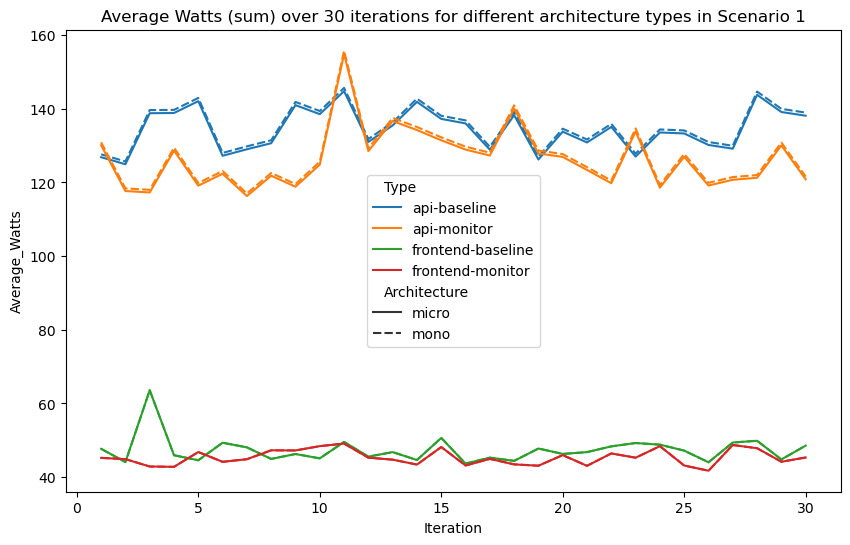

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/1859675840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/1859675840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')


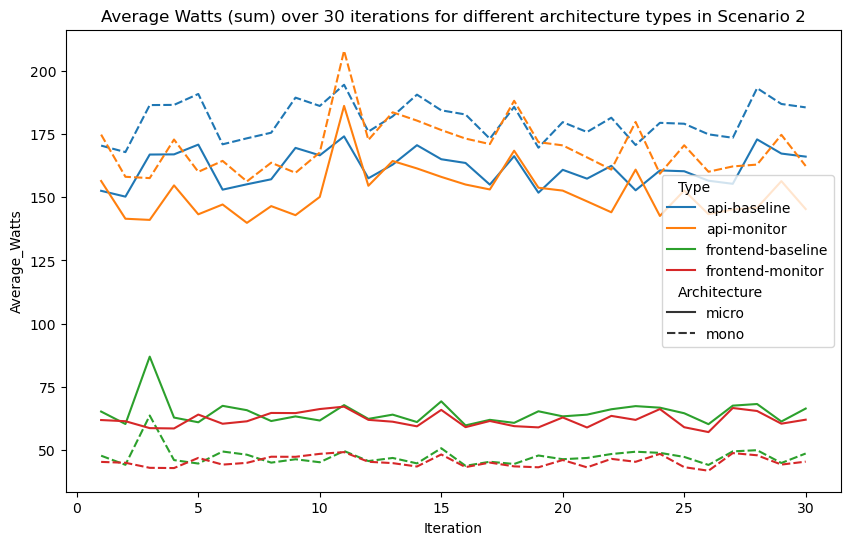

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/1859675840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/1859675840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')


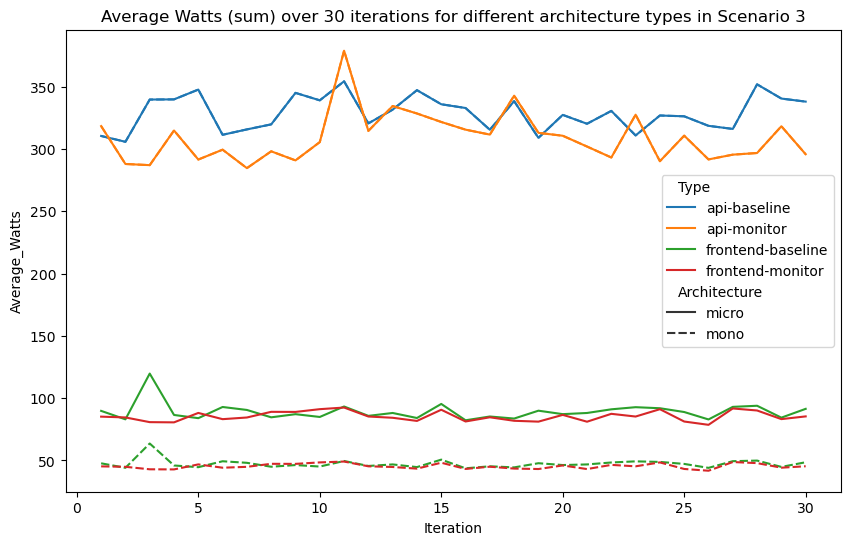

In [102]:
# Call the function for each scenario
for scenario in range(1, 4):
    # plot_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='mean')
    # plot_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='sum')
    plot_architecture_types_for_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='sum')
    
# plot_architecture_types(df, output_directory, 'Average_Watts', aggregation='mean')

# plot_all_scenarios(df, output_directory, 'Average_Watts', aggregation='mean')
# plot_all_scenarios(df, output_directory, 'Average_Watts', aggregation='sum')

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


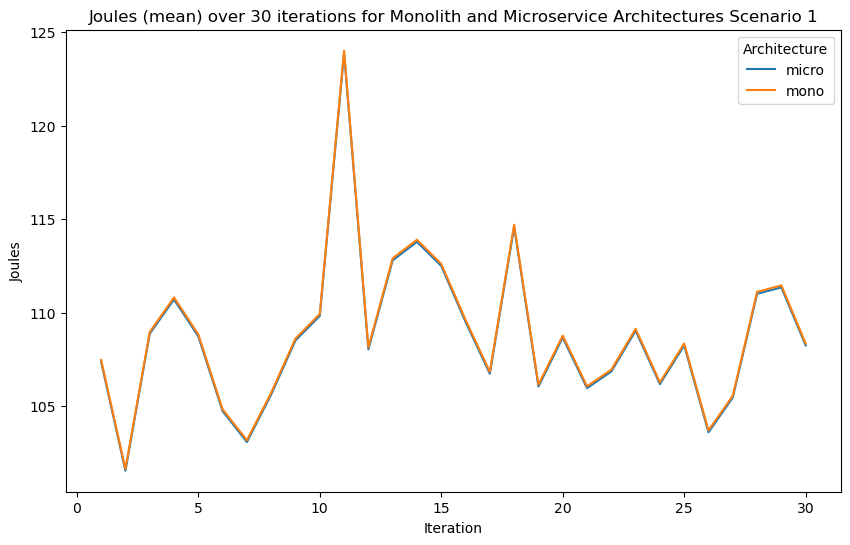

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


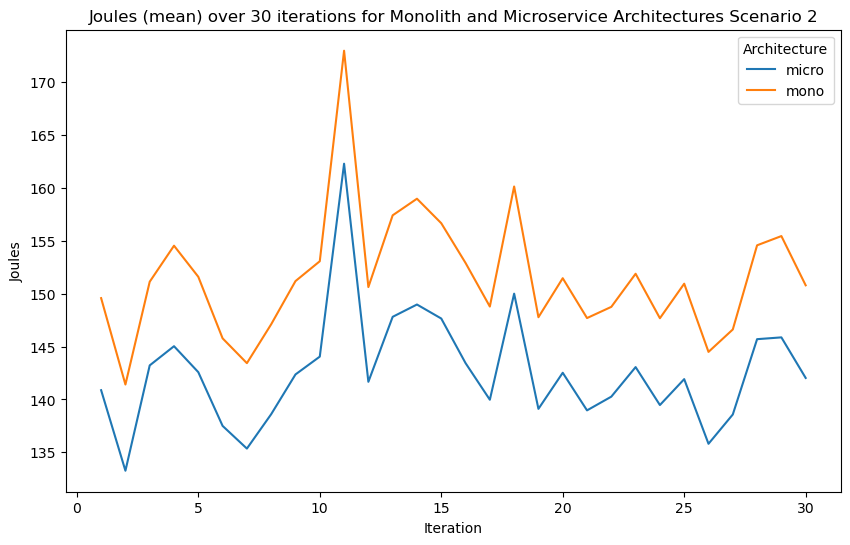

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


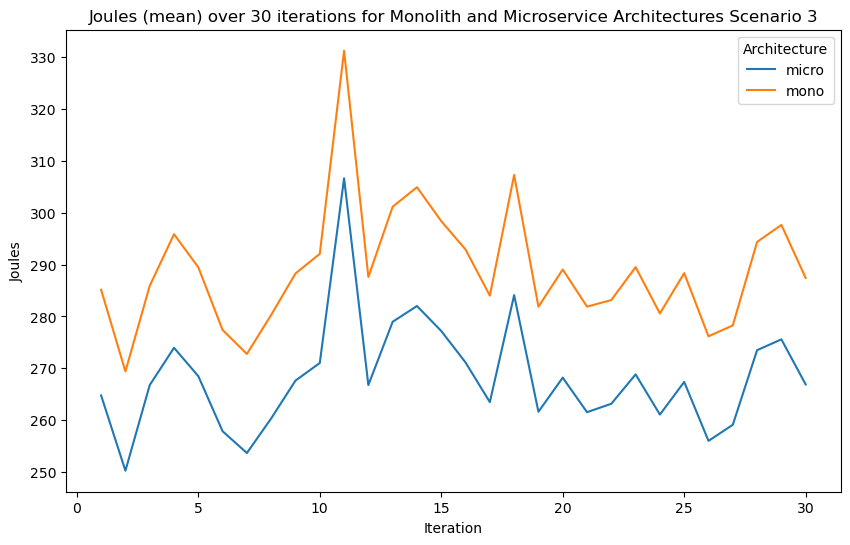

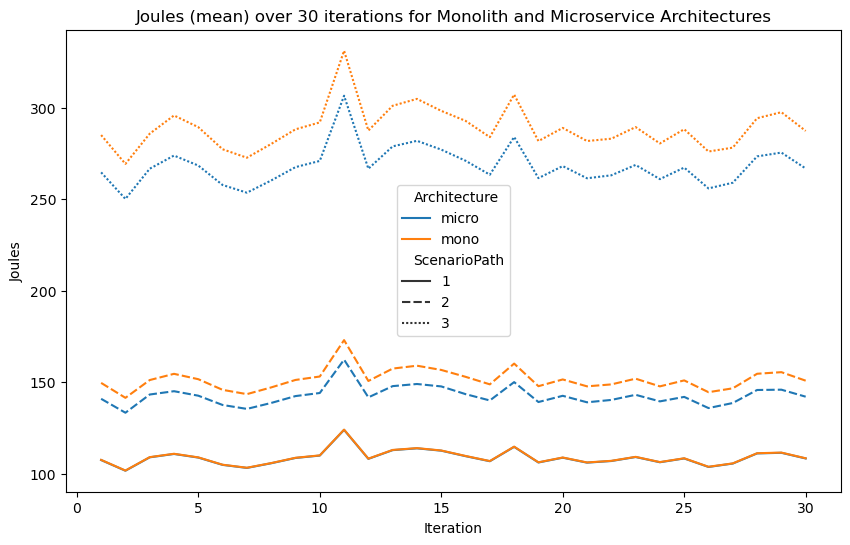

,Iteration,Architecture,ScenarioPath,Joules
54,10,micro,1,109.824548
55,10,micro,2,144.051213
56,10,micro,3,271.000091
57,10,mono,1,109.928214
58,10,mono,2,153.069921
59,10,mono,3,292.069045
114,20,micro,1,108.665966
115,20,micro,2,142.523989
116,20,micro,3,268.175680
117,20,mono,1,108.768742


In [103]:
# Call the function for each scenario
for scenario in range(1, 4):
    plot_scenario(df, scenario, output_directory, 'Joules', aggregation='mean')
    # plt.ylim(0,1600)

    # plot_scenario(df, scenario, output_directory, 'Joules', aggregation='sum')

plot_all_scenarios(df, output_directory, 'Joules', aggregation='mean')
# plot_all_scenarios(df, output_directory, 'Joules', aggregation='sum')

plot_and_export_selected_iterations(df, output_directory, 'Joules', aggregation='mean')

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


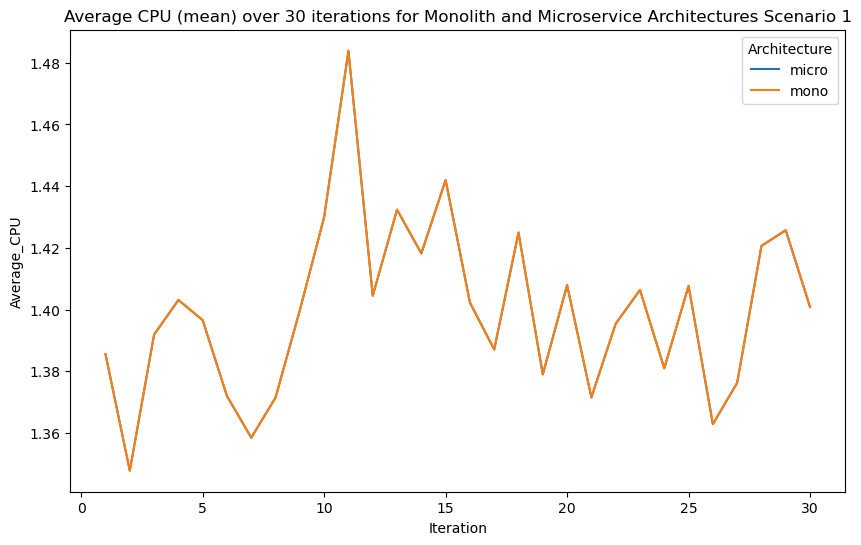

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


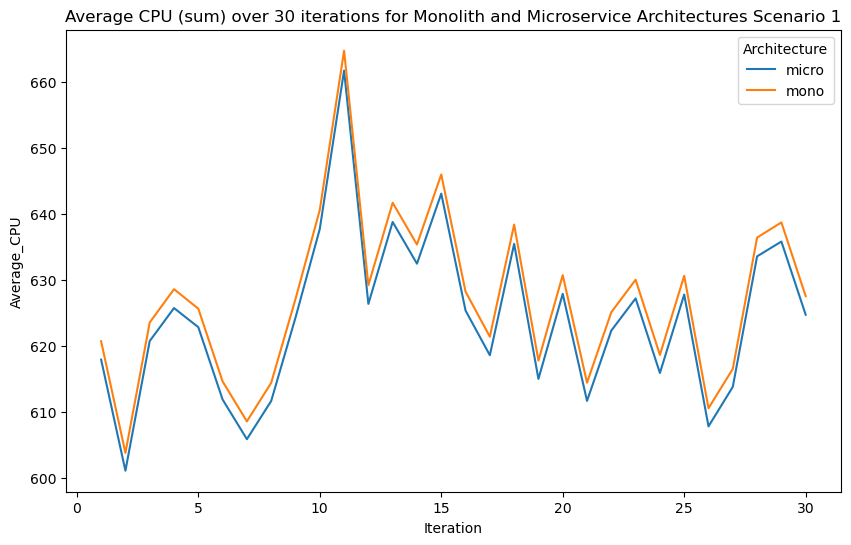

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


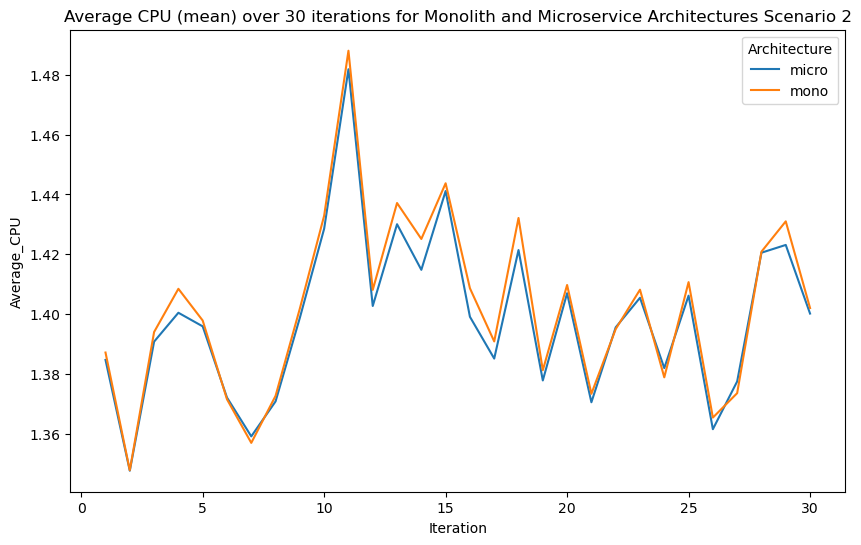

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


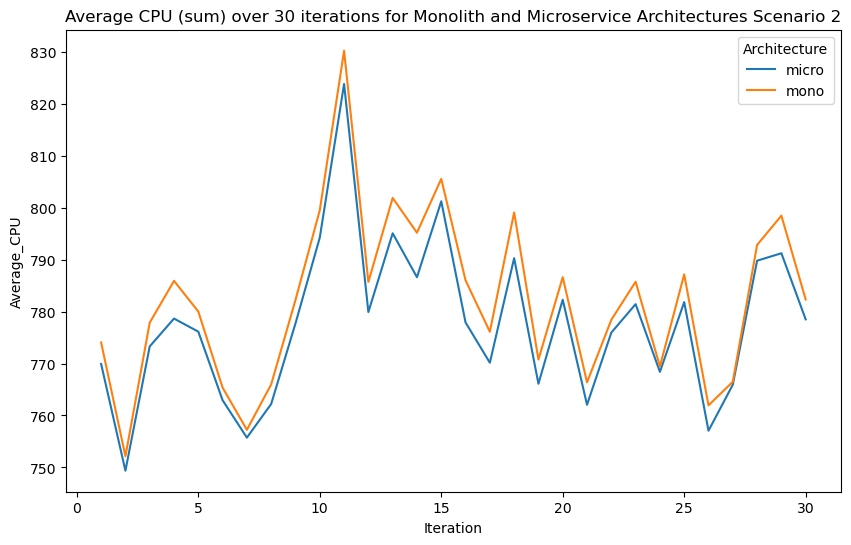

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


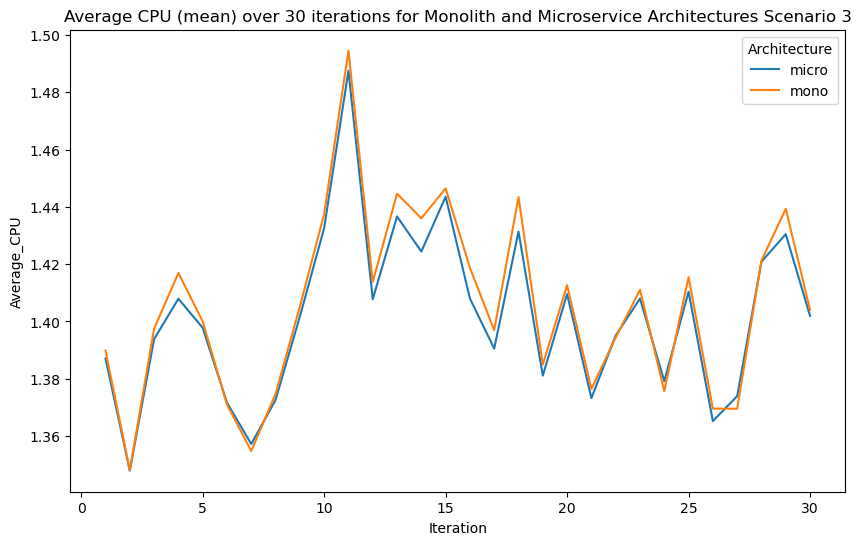

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_22124/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


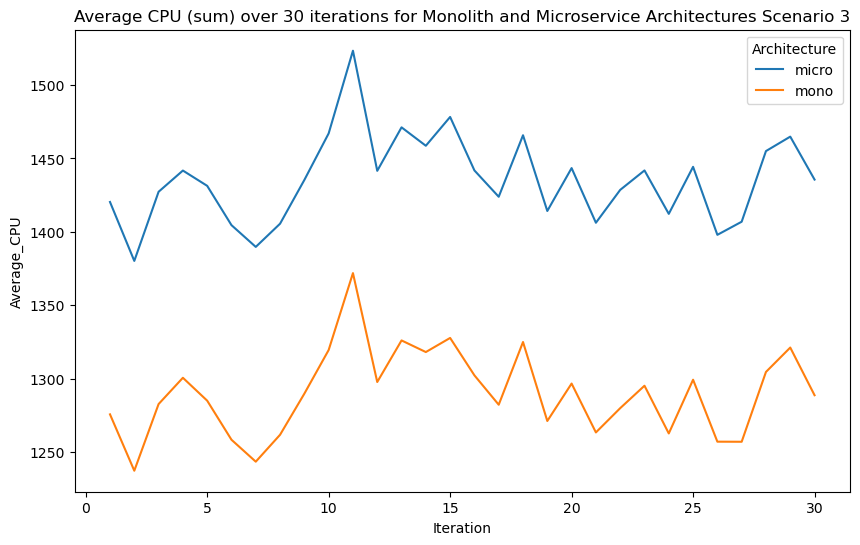

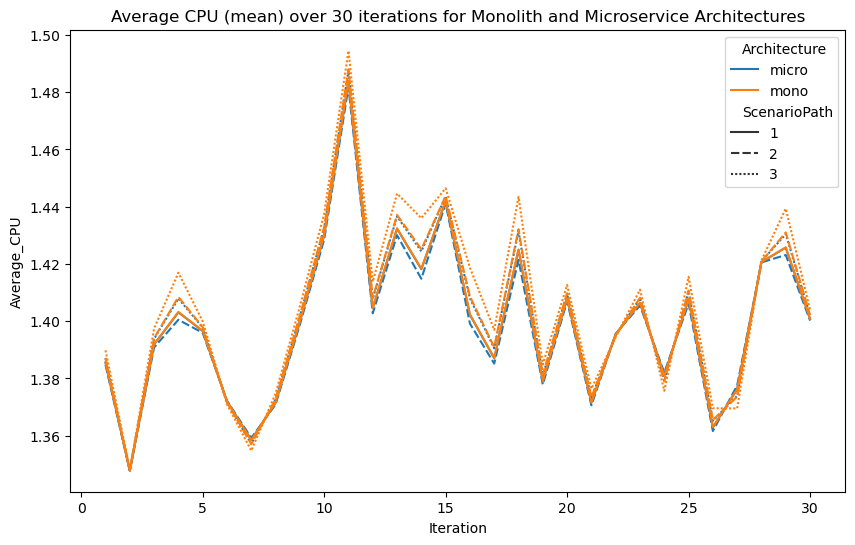

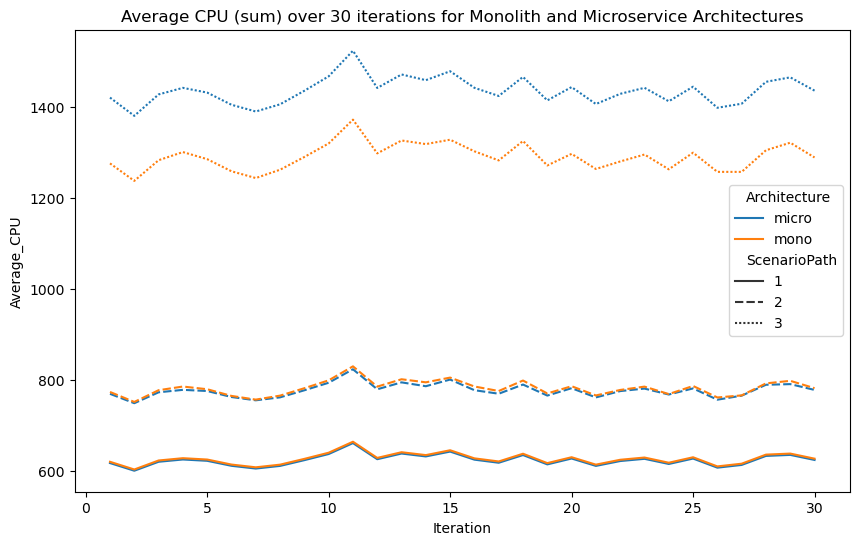

In [104]:
# Call the function for each scenario
for scenario in range(1, 4):
    plot_scenario(df, scenario, output_directory, 'Average_CPU', aggregation='mean')
    plot_scenario(df, scenario, output_directory, 'Average_CPU', aggregation='sum')

plot_all_scenarios(df, output_directory, 'Average_CPU', aggregation='mean')
plot_all_scenarios(df, output_directory, 'Average_CPU', aggregation='sum')

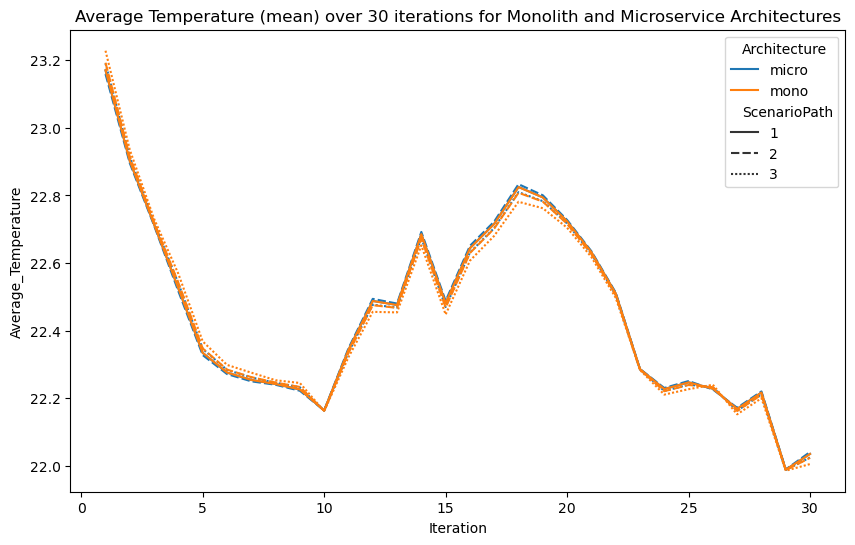

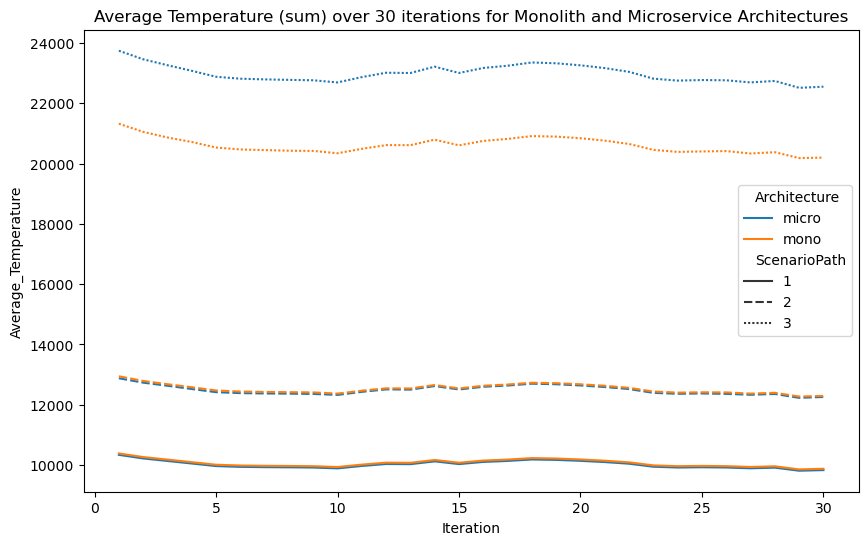

In [105]:
plot_all_scenarios(df, output_directory, 'Average_Temperature', aggregation='mean')
plot_all_scenarios(df, output_directory, 'Average_Temperature', aggregation='sum')